In [6]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes

from msrest.authentication import CognitiveServicesCredentials
from array import array
import os
from PIL import Image
import sys
import time
import matplotlib.pyplot as plt
from skimage import io
import numpy as np

'''
Authenticate
Authenticates your credentials and creates a client.
'''
subscription_key = os.environ["VISION_KEY"]
endpoint = os.environ["VISION_ENDPOINT"]

computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))

In [7]:
dir = "images/"

total = 20
tp = 0
tn = 0
fp = 0
fn = 0


for file in os.listdir(dir):
    img = open(dir + file, "rb")
    result = computervision_client.analyze_image_in_stream(img, visual_features=[VisualFeatureTypes.objects])
    bike_found = False
    for ob in result.objects:
        if ob.object_property in ["bicycle", "cycle"]:
            bike_found = True

    if file.find("bike") == -1:
        if bike_found: fp += 1
        else: tn += 1
    else:
        if bike_found: tp += 1
        else: fn += 1

print(f"Accuracy: {(tp + tn) / total}")
print(f"Precision: {tp / (tp + fp)}")
print(f"Recall: {tp / (tp + fn)}")


Accuracy: 0.95
Precision: 1.0
Recall: 0.9


In [8]:
# First rectangle (true values) (a, b) (a - upper left, b - lower right), point = (x, y)
# Second rectangle (detected values) (c, d) (c - upper left, d - lower right), point = (x, y)
def metrics(a, b, c, d):
    m = (max(a[0], c[0]), max(a[1], c[1]))
    n = (min(b[0], d[0]), min(b[1], d[1]))

    intersection_area = (n[0] - m[0]) * (n[1] - m[1])
    first_rectangle_area = (b[0] - a[0]) * (b[1] - a[1])
    second_rectangle_area = (d[0] - c[0]) * (d[1] - c[1])
    union_area = first_rectangle_area + second_rectangle_area - intersection_area

    return [m, n, intersection_area / union_area, intersection_area / second_rectangle_area, intersection_area / first_rectangle_area]
    # returns Intersection rectangle (m, n), IoU, Precision, Recall

bike08.jpg: 
{'additional_properties': {}, 'rectangle': <azure.cognitiveservices.vision.computervision.models._models_py3.BoundingRect object at 0x12b697a10>, 'object_property': 'person', 'confidence': 0.918, 'parent': None}

bike09.jpg: 
{'additional_properties': {}, 'rectangle': <azure.cognitiveservices.vision.computervision.models._models_py3.BoundingRect object at 0x12ba5c8d0>, 'object_property': 'bicycle', 'confidence': 0.777, 'parent': <azure.cognitiveservices.vision.computervision.models._models_py3.ObjectHierarchy object at 0x12ba5c990>}

bike07.jpg: 
{'additional_properties': {}, 'rectangle': <azure.cognitiveservices.vision.computervision.models._models_py3.BoundingRect object at 0x12ba5de90>, 'object_property': 'person', 'confidence': 0.8, 'parent': None}
{'additional_properties': {}, 'rectangle': <azure.cognitiveservices.vision.computervision.models._models_py3.BoundingRect object at 0x12ba5df90>, 'object_property': 'bicycle', 'confidence': 0.859, 'parent': <azure.cognitives

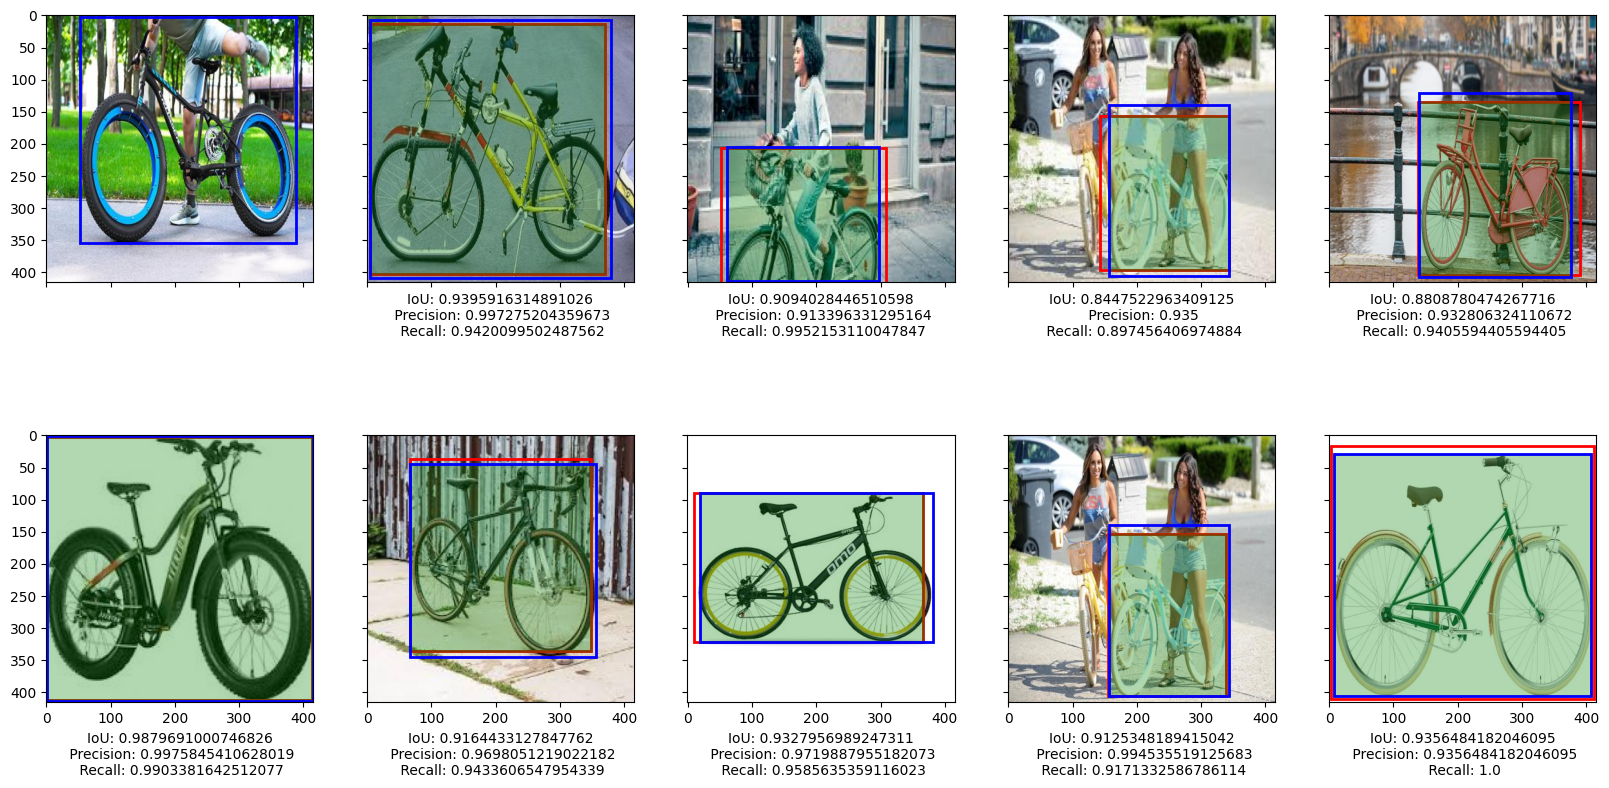

In [9]:
img_data = {
    'bike08.jpg': {'xy': (52, 3), 'width': 336, 'height': 351}, 
    'bike09.jpg': {'xy': (5, 7), 'width': 375, 'height': 402}, 
    'bike07.jpg': {'xy': (61, 205), 'width': 237, 'height': 209}, 
    'bike06.jpg': {'xy': (156, 140), 'width': 188, 'height': 266}, 
    'bike10.jpg': {'xy': (140, 121), 'width': 236, 'height': 286}, 
    'bike04.jpg': {'xy': (1, 1), 'width': 414, 'height': 413}, 
    'bike05.jpg': {'xy': (67, 44), 'width': 289, 'height': 301}, 
    'bike02.jpg': {'xy': (19, 90), 'width': 362, 'height': 231}, 
    # 'bike03.jpg': {'xy': (60, 144), 'width': 138, 'height': 247},
    'bike03.jpg': {'xy': (156, 140), 'width': 188, 'height': 266}, 
    "bike1.jpg": {"xy": (7, 29), "width": 401, "height": 376}
}

fig, ax = plt.subplots(2, 5, figsize=(20, 10), sharex=True, sharey=True)
i, j = 0, 0
dir = "images/"
for file in os.listdir(dir):

    if file.find("bike") == -1: continue

    print(f"{file}: ")

    im = plt.imread(dir + file)
    ax[i][j].imshow(im)

    img = open(dir + file, "rb")
    result = computervision_client.analyze_image_in_stream(img, visual_features=[VisualFeatureTypes.objects])
    for ob in result.objects:
        print(ob)

        if ob.object_property in ["bicycle", "cycle"]:
            x1, y1, x2, y2 = ob.rectangle.x, ob.rectangle.y, ob.rectangle.x + ob.rectangle.w, ob.rectangle.y + ob.rectangle.h

            ax[i][j].add_patch(plt.Rectangle(xy = (ob.rectangle.x, ob.rectangle.y), width = ob.rectangle.w, 
                                            height = ob.rectangle.h, fill = False, 
                                            color = "red", linewidth = 2))
            
            metricsResult = metrics(
                img_data[file]["xy"], 
                (img_data[file]["xy"][0] + img_data[file]["width"], img_data[file]["xy"][1] + img_data[file]["height"]), 
                (x1, y1),
                (x2, y2)
            )

            ax[i][j].add_patch(plt.Rectangle(xy = metricsResult[0], width = metricsResult[1][0] - metricsResult[0][0],
                                            height = metricsResult[1][1] - metricsResult[0][1], fill = True,
                                            color = "green", linewidth = 2, alpha = 0.3))

            ax[i][j].set_xlabel(f'IoU: {metricsResult[2]}\n Precision: {metricsResult[3]}\n Recall: {metricsResult[4]}')
        
        
    ax[i][j].add_patch(plt.Rectangle(xy = img_data[file]["xy"], width = img_data[file]["width"], 
                                     height = img_data[file]["height"], fill = False, 
                                     color = "blue", linewidth = 2))

    print()

    j+=1
    if j % 5 == 0: 
        i += 1
        j = 0

plt.show()